In [1]:
!pip install pandas numpy scikit-learn transformers datasets evaluate plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import sklearn
import plotly.express as px
import nltk
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression

In [3]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
from datasets import load_dataset

In [ ]:
## Data Collection: https://huggingface.co/datasets/financial_phrasebank

dataset = load_dataset('financial_phrasebank', 'sentences_allagree')

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [ ]:
tmp_df = dataset['train'].to_pandas()

In [ ]:
tmp_df['label'].unique()

array([1, 2, 0])

In [ ]:
tmp_df.head()

sentence  label
0  According to Gran , the company has no plans t...      1
1  For the last quarter of 2010 , Componenta 's n...      2
2  In the third quarter of 2010 , net sales incre...      2
3  Operating profit rose to EUR 13.1 mn from EUR ...      2
4  Operating profit totalled EUR 21.1 mn , up fro...      2

In [ ]:
## Exploratory Data Analysis (EDA)

In [ ]:
import plotly.express as px

In [ ]:
fig = px.pie(tmp_df, names
             = 'label', labels = 'label')
fig

In [ ]:
tmp_df['length_text'] = tmp_df['sentence'].apply(lambda x: len(str(x)))

In [ ]:
fig = px.box(tmp_df, x = 'label', y = 'length_text')
fig

In [ ]:
tmp_df.head()

sentence  label  length_text
0  According to Gran , the company has no plans t...      1          127
1  For the last quarter of 2010 , Componenta 's n...      2          193
2  In the third quarter of 2010 , net sales incre...      2          125
3  Operating profit rose to EUR 13.1 mn from EUR ...      2          122
4  Operating profit totalled EUR 21.1 mn , up fro...      2          103

In [ ]:
fig = px.histogram(tmp_df, x='length_text', template='plotly_white', title='Text counts by length')
fig.update_xaxes(categoryorder='total descending', title='Number of words')
fig.show()

In [ ]:
## Pre-processing & Text Cleaning

import re

def clean_text(x):
  x = x.lower()
  x = re.sub('[^a-zA-Z0-9.]', ' ', x)
  x = re.sub('( ){2,}',' ', x)
  return x

tmp_df['cleaned_text'] = tmp_df['sentence'].apply(clean_text)

In [ ]:
tmp_df.head()

sentence  label  length_text  \
0  According to Gran , the company has no plans t...      1          127   
1  For the last quarter of 2010 , Componenta 's n...      2          193   
2  In the third quarter of 2010 , net sales incre...      2          125   
3  Operating profit rose to EUR 13.1 mn from EUR ...      2          122   
4  Operating profit totalled EUR 21.1 mn , up fro...      2          103   

                                        cleaned_text  
0  according to gran the company has no plans to ...  
1  for the last quarter of 2010 componenta s net ...  
2  in the third quarter of 2010 net sales increas...  
3  operating profit rose to eur 13.1 mn from eur ...  
4  operating profit totalled eur 21.1 mn up from ...

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

text = tmp_df['cleaned_text']
model = CountVectorizer(ngram_range = (1, 1), stop_words='english')
matrix = model.fit_transform(text).toarray()
df_output = pd.DataFrame(data = matrix, columns = model.get_feature_names_out())
df_output.T.tail(5)

0     1     2     3     4     5     6     7     8     9     ...  2254  \
zgody      0     0     0     0     0     0     0     0     0     0  ...     0   
zinc       0     0     0     0     0     0     0     0     0     0  ...     0   
zoltan     0     0     0     0     0     0     0     0     0     0  ...     0   
zone       0     0     0     0     0     0     0     0     0     0  ...     0   
zu         0     0     0     0     0     0     0     0     0     0  ...     0   

        2255  2256  2257  2258  2259  2260  2261  2262  2263  
zgody      0     0     0     0     0     0     0     0     0  
zinc       0     0     0     0     0     0     0     0     0  
zoltan     0     0     0     0     0     0     0     0     0  
zone       0     0     0     0     0     0     0     0     0  
zu         0     0     0     0     0     0     0     0     0  

[5 rows x 2264 columns]

In [ ]:
def get_ngrams(text, ngram_from=2, ngram_to=2, n=None, max_features=20000):

    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to),
                          max_features = max_features,
                          stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

    return words_freq[:n]

In [ ]:
bigrams = get_ngrams(tmp_df['cleaned_text'], ngram_from=2, ngram_to=2, n=150)
bigrams_df = pd.DataFrame(bigrams)
bigrams_df.columns=["Bigram", "Frequency"]
bigrams_df.head()

Bigram  Frequency
0                eur mn        165
1             net sales        147
2      operating profit        145
3                mn eur        119
4  corresponding period         91

In [ ]:
px.bar(bigrams_df, x = 'Bigram', y = 'Frequency')

In [ ]:
## Train Sentiment Analysis ML Models using TF-IDF / BoW !

In [ ]:
### BoW

In [ ]:
vectorizer = CountVectorizer(max_features = 1000, min_df = 0.1, stop_words='english')

In [ ]:
from sklearn.model_selection import train_test_split

X = tmp_df['cleaned_text'].values
X = vectorizer.fit_transform(X)
y = tmp_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )

In [ ]:
vectorizer.get_feature_names_out()[:10]

array(['company', 'eur', 'mn', 'net', 'profit', 'sales'], dtype=object)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
y_predictions = clf.predict(X_test)

In [ ]:
accuracy_score( y_test, y_predictions)

0.7108167770419426

In [ ]:
# BoW + N-grams

In [ ]:
vectorizer = CountVectorizer(max_features = 1000, min_df = 0.05, stop_words='english', ngram_range=(1,3))

X = tmp_df['cleaned_text'].values
X = vectorizer.fit_transform(X)
y = tmp_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predictions = clf.predict(X_test)
print('Accuracy (BoW + Ngrams): ', accuracy_score( y_test, y_predictions) )

Accuracy (BoW + Ngrams):  0.7704194260485652


In [ ]:
# TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features = 10000, stop_words='english')

X = tmp_df['cleaned_text'].values
X = vectorizer.fit_transform(X)
y = tmp_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predictions = clf.predict(X_test)
print('Accuracy (TF-IDF): ', accuracy_score( y_test, y_predictions) )

Accuracy (TF-IDF):  0.8211920529801324


In [ ]:
# TF-IDF + N-grams

In [ ]:
vectorizer = TfidfVectorizer(max_features = 10000, stop_words='english', ngram_range=(1,4))

X = tmp_df['cleaned_text'].values
X = vectorizer.fit_transform(X)
y = tmp_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predictions = clf.predict(X_test)
print('Accuracy (TF-IDF + Ngrams): ', accuracy_score( y_test, y_predictions) )

Accuracy (TF-IDF + Ngrams):  0.8101545253863135


In [ ]:
## Train Word2Vec for Sentiment Analysis

In [ ]:
# Gensim / sklearn
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [ ]:
texts = [i.split() for i in tmp_df['cleaned_text']]
model = Word2Vec(sentences=texts, vector_size=300, window=10, min_count=2, workers=4)

In [ ]:
print(len(model.wv))

2989


In [ ]:
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def document_vector(doc):
    word_vectors = [model.wv[word] for word in doc if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

tmp_df['word2vec_avg'] = tmp_df['cleaned_text'].apply(lambda x: document_vector(x.split()))

X_train, X_test, y_train, y_test = train_test_split(tmp_df['word2vec_avg'].tolist(), tmp_df['label'], test_size=0.2, random_state=42)

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7262693156732892


In [ ]:
## Topic Modelling (LDA / NMF ) & Visualization of Topcis

In [ ]:
import os
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1), min_df = 0.1,
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(tmp_df['cleaned_text'].tolist())

# Define the number of topics or components
num_components=5
# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)
# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)
# Get Components
lda_components=model.components_

In [ ]:
# Print the topics with their terms
terms = tfidf.get_feature_names_out()
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['1', 'net', 'profit', 'eur', 'sales', 'company', 's']
Topic 1:  ['mn', 'eur', 'profit', 'sales', 'net', '1', 's']
Topic 2:  ['s', 'company', 'sales', 'net', 'eur', 'profit', '1']
Topic 3:  ['eur', 'profit', 'net', 'sales', 'company', '1', 's']
Topic 4:  ['company', 'sales', 'net', 'profit', 's', 'eur', '1']


Number of unique tokens: 551
Number of documents: 2264
[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]
[(0, '0.062*"at" + 0.045*"value" + 0.041*"on" + 0.037*"financial" + 0.033*"its" + 0.029*"billion" + 0.028*"unit" + 0.025*"report" + 0.023*"percent" + 0.019*"pct"'), (1, '0.084*"about" + 0.074*"capital" + 0.053*"by" + 0.052*"bank" + 0.045*"shares" + 0.044*"are" + 0.038*"including" + 0.036*"markets" + 0.034*"had" + 0.033*"negative"'), (2, '0.116*"mln" + 0.073*"euro" + 0.064*"finnish" + 0.060*"oyj" + 0.054*"said" + 0.051*"net" + 0.041*"its" + 0.038*"profit" + 0.036*"million" + 0.036*"today"'), (3, '0.086*"as" + 0.034*"is" + 0.027*"has" + 0.026*"that" + 0.026*"company" + 0.025*"contract" + 0.025*"services" + 0.020*"well" + 0.020*"it" + 0.019*"finland"'), (4, '0.102*"business" + 0.074*"operations" + 0.070*"finland" + 0.034*"industry" + 0.032*"media" + 0.028*"company" + 0.028*"products" + 0.024*"development" + 0.022*"are" + 0.021*"ceo"'), (5, '0.136*"share

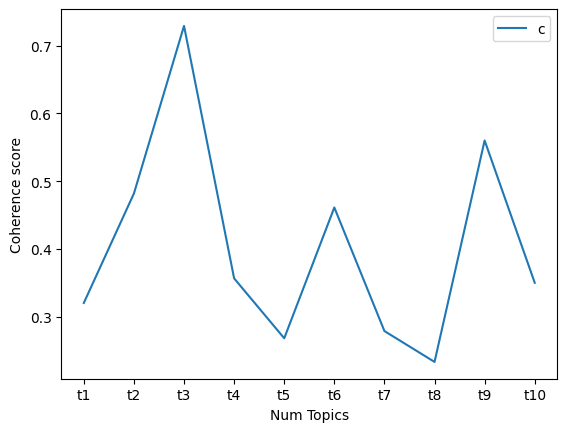

In [ ]:
from gensim.corpora.dictionary import Dictionary
import gensim
from gensim.models import Phrases

#Remove rare & common tokens
# Create a dictionary representation of the documents.
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

docs = list(sent_to_words(tmp_df['cleaned_text'].tolist()))


bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
# Set parameters.
num_topics = 10
chunksize = 500
passes = 20
iterations = 400
eval_every = 1

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(1,num_topics+1):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname,coherence_ldas)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [ ]:
!pip install pyldavis

In [ ]:
# Check: https://www.kaggle.com/code/trnduythanhkhttt/lda-and-topic-coherence-score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
## Fine-tune LMs for Sentiment Analysis (BERT, RoBERTa, AlBERT, DistilBERT....)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [1]:
from datasets import load_dataset

dataset = load_dataset("financial_phrasebank", "sentences_allagree")
dataset["train"][10]

{'sentence': 'Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .',
 'label': 2}

In [2]:
len(dataset['train'])

2264

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [4]:
small_train_dataset = tokenized_datasets["train"].select(range(1812))
small_eval_dataset = tokenized_datasets["train"].select(range(1812,2264))

In [5]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
!pip install accelerate -U
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [7]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [12]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="steps")

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [11]:
trainer.train()

TrainOutput(global_step=681, training_loss=0.14459510976872605, metrics={'train_runtime': 521.1115, 'train_samples_per_second': 10.432, 'train_steps_per_second': 1.307, 'total_flos': 1430284538769408.0, 'train_loss': 0.14459510976872605, 'epoch': 3.0})

In [17]:
trainer.evaluate()

{'eval_loss': 1.5169097185134888,
 'eval_accuracy': 0.7522123893805309,
 'eval_runtime': 14.3853,
 'eval_samples_per_second': 31.421,
 'eval_steps_per_second': 3.962,
 'epoch': 3.0}

In [19]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.8 MB/s eta 0:00:00


In [33]:
import shap
import torch
import scipy as sp

In [22]:
def f(x):
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=128, truncation=True)
            for v in x
        ]
    ).cuda()
    attention_mask = (tv != 0).type(torch.int64).cuda()
    outputs = model(tv, attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [25]:
labels = sorted(model.config.label2id, key=model.config.label2id.get)

explainer = shap.Explainer(f, tokenizer, output_names=labels)

In [39]:
labels

['LABEL_0', 'LABEL_1', 'LABEL_2']

In [34]:
shap_values = explainer(dataset['train']['sentence'][:3])

PartitionExplainer explainer:  67%|██████▋   | 2/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:15,  7.60s/it]


In [38]:
dataset['train'][:3]

{'sentence': ['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .'],
 'label': [1, 2, 2]}

In [37]:
shap.plots.text(shap_values)

In [40]:
## BERTopic

In [41]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 27.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.2 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039189 sha256=5452865a45a8ebe279216483f2753b7a1355b814fc1bb3122b343923770e1e9b
  Stored in di

In [44]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

docs = dataset['train']['sentence']

In [45]:
docs[:1]

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .']

In [46]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [47]:
topic_model.get_topic_info()

Topic  Count                                          Name  \
0      -1    826                              -1_and_the_of_in   
1       0    126                               0_be_on_will_at   
2       1     89                   1_nokia_mobile_and_networks   
3       2     73                        2_finland_russia_is_in   
4       3     66                    3_not_disclosed_no_details   
5       4     64                       4_decreased_sales_by_in   
6       5     58                           5_hel_oyj_today_usd   
7       6     49                           6_mln_euro_net_2006   
8       7     45             7_customers_including_as_services   
9       8     43                8_shares_voting_rights_capital   
10      9     42                      9_eps_earnings_per_share   
11     10     40                    10_mn_operating_eur_profit   
12     11     36    11_equipment_heating_includes_installation   
13     12     34             12_value_contract_about_contracts   
14     13     32                      13_mn_rose_operating_eur   
15     14     30       14_passenger_finnair_percent_passengers   
16     15     30                    15_million_grew_profit_net   
17     16     29     16_employs_employees_people_approximately   
18     17     27              17_savings_investment_cost_total   
19     18     27           18_ceo_appointed_chairman_president   
20     19     26                 19_increase_sales_expects_net   
21     20     26                     20_sales_net_by_increased   
22     21     25         21_respectively_period_increased_both   
23     22     25                       22_pretax_eur_mn_profit   
24     23     23                       23_loss_mn_compared_eur   
25     24     22                      24_value_order_orders_is   
26     25     22               25_unit_plate_hook_distribution   
27     26     21         26_cargotec_cranes_handling_container   
28     27     20          27_option_stock_options_subscription   
29     28     20                   28_ebit_margin_was_compared   
30     29     19                       29_sq_area_metres_gross   
31     30     18                 30_tonnes_paper_capacity_tons   
32     31     18                     31_meat_fish_food_tehtaat   
33     32     17              32_aspo_aspocomp_structure_group   
34     33     17                        33_taxes_before_mn_eur   
35     34     17                      34_mn_fell_eur_operating   
36     35     16                35_beer_liters_percent_million   
37     36     16                   36_capman_real_estate_funds   
38     37     15           37_dividend_propose_directors_board   
39     38     14       38_elcoteq_manufacturing_electronics_se   
40     39     14              39_flow_cash_negative_activities   
41     40     14                 40_market_share_london_shares   
42     41     13            41_board_directors_meeting_general   
43     42     13    42_analysis_pharmaceutical_market_research   
44     43     13                  43_nasdaq_omx_rules_helsinki   
45     44     13            44_basware_invoices_invoice_format   
46     45     11  45_scanfil_electronics_manufacturer_supplier   
47     46     10                       46_building_dans_toy_re   

                                       Representation  \
0   [and, the, of, in, to, for, company, is, will,...   
1   [be, on, will, at, the, statements, report, ex...   
2   [nokia, mobile, and, networks, as, services, h...   
3   [finland, russia, is, in, production, plants, ...   
4   [not, disclosed, no, details, were, disclose, ...   
5   [decreased, sales, by, in, fell, net, eur, mn,...   
6   [hel, oyj, today, usd, finnish, said, net, 201...   
7   [mln, euro, net, 2006, oyj, finnish, profit, s...   
8   [customers, including, as, services, and, busi...   
9   [shares, voting, rights, capital, share, numbe...   
10  [eps, earnings, per, share, eur0, diluted, eur...   
11  [mn, operating, eur, profit, down, totaled, to...   
12  [equipment, heating, inc

In [48]:
topic_model.get_topic(0)

[('be', 0.03555079398419963),
 ('on', 0.03506756842854212),
 ('will', 0.03139848593581804),
 ('at', 0.028006172321338754),
 ('the', 0.024778220636829135),
 ('statements', 0.023842722807687455),
 ('report', 0.02317783943834615),
 ('expected', 0.02269517854023339),
 ('is', 0.021916911094010876),
 ('financial', 0.02104546295625212)]

In [54]:
topic_model.get_topic(9)

[('eps', 0.16449277036814933),
 ('earnings', 0.12622683650307728),
 ('per', 0.12166727769714658),
 ('share', 0.10064902554814786),
 ('eur0', 0.0986218397639041),
 ('diluted', 0.06951889482486784),
 ('eur', 0.05178305665349977),
 ('versus', 0.049507333628698774),
 ('from', 0.03805386843095088),
 ('eur1', 0.03615557590928976)]

In [55]:
topic_model.visualize_topics()

In [57]:
topic_model.visualize_documents(docs)

In [58]:
topic_model.visualize_heatmap()

In [ ]:
## Data Collection: https://huggingface.co/datasets/financial_phrasebank
## Exploratory Data Analysis (EDA)
## Pre-processing & Text Cleaning
## Train Sentiment Analysis ML Models using TF-IDF / BoW !
## Train Word2Vec for Sentiment Analysis
## Topic Modelling (LDA / NMF ) & Visualization of Topcis
## Fine-tune LMs for Sentiment Analysis (BERT, RoBERTa, AlBERT, DistilBERT....)
## Model Evaluation & Compare (Metrics, Confusion Matrix....)
## Model Explainability (SHAP....)
## Model Inference (pipeline: sentiment-analysis) ...
## Model Deplyoment & Sharing (web app: Optional)